## Using Twitter official API

In [89]:
import twitter
from TWITTER_API_KEYS import *  # tell students not to put redentials on github
auth = twitter.oauth.OAuth(ACCESS_TOKEN, ACCESS_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
twitter_api = twitter.Twitter(auth=auth)

Obtaining a search result. This is a bit more complicated than requesting n=1000 tweets. Some issues:

1. We need to parse the information returned, as it isn't in a neat Dataframe for us to begin analyzing.

2. We need to make multiple requests to get an amount good for analysis. The limit for the Twitter API is 100 tweets per request and 180 requests per 15 minutes, which gives us 18,000 for 15 minutes.

3. We need to make sure we're not getting duplicate tweets. Since tweets and tweet counts are always changing, we do this with tweet IDs. For the guide I used, see: https://dev.twitter.com/rest/public/timelines

### Let's start by grabbing the first result.

In [90]:
# https://dev.twitter.com/rest/reference/get/search/tweets
# general queries: https://dev.twitter.com/rest/public/search

SEARCH = "Super Bowl"  # note that no tweets older than 1 week will be found
search_results = twitter_api.search.tweets(q=SEARCH, count=100)

Now let's investigate the structure of this object.

In [91]:
type(search_results)

twitter.api.TwitterDictResponse

In [92]:
search_results.keys()

dict_keys(['statuses', 'search_metadata'])

Since we want to look at the actual text of the tweets, let's grab the values instead.

In [120]:
results = search_results.values()
results = list(results)  # conver the dict_view object to a indexable list

Check out the results (too long to print)

In [121]:
# results

Looks like we have the results from 100 tweets. Now we can extract the text. Some experimentation gives us the structure of the `results` list.

`results[0: search data or 1: metadata][tweet #][information type]`

**Let's extract the text and turn it into a dataframe.**

In [157]:
# Figure out what keys are available in the python dictionary
results[0][0].keys()

dict_keys(['in_reply_to_user_id', 'geo', 'metadata', 'user', 'retweeted', 'place', 'extended_entities', 'source', 'id_str', 'possibly_sensitive', 'in_reply_to_user_id_str', 'id', 'truncated', 'retweet_count', 'contributors', 'coordinates', 'in_reply_to_status_id', 'retweeted_status', 'in_reply_to_screen_name', 'lang', 'is_quote_status', 'in_reply_to_status_id_str', 'entities', 'text', 'favorited', 'favorite_count', 'created_at'])

In [149]:
results[0][0]['text']

"RT @GMA: Retweet if you're picking the @AtlantaFalcons to win the Super Bowl! \n\n#SB51 #Falcons #RiseUp https://t.co/Wvm8BlrFbC"

In [134]:
results[0]

list

In [108]:
tweets = []
for i in range(100):
    tweets.append(results[0][i]['text'])
tweets[0:2]  # take a look at the first 2 tweets

["RT @GMA: Retweet if you're picking the @AtlantaFalcons to win the Super Bowl! \n\n#SB51 #Falcons #RiseUp https://t.co/Wvm8BlrFbC",
 "Ain't shit else to do So I might as well watch this corny shit..oh yeah #GoFalcons #RiseUp cause I hate New England — watching Super Bowl LI"]

In [119]:
import pandas as pd
dat = pd.DataFrame(pd.Series(tweets), columns=['tweet_text'])
dat.head()

,tweet_text
0,RT @GMA: Retweet if you're picking the @Atlant...
1,Ain't shit else to do So I might as well watch...
2,RT @SoDamnTrue: I have yet to see a Super Bowl...
3,#SuperBowl livestream 👉 https://t.co/CTdkHRdcDd
4,RT @SportsCenter: RT if you think the Falcons ...


Awesome. We got and processed our data. Now let's grab a lot more tweets. 1000 tweets, or 10 requests, should be enough to play with.

From https://dev.twitter.com/rest/public/timelines:

To use max_id correctly, an application’s first request to a timeline endpoint should only specify a count. When processing this and subsequent responses, keep track of the lowest ID received. This ID should be passed as the value of the max_id parameter for the next request, which will only return Tweets with IDs lower than or equal to the value of the max_id parameter. Note that the max_id parameter is inclusive.

In [215]:
def grab_tweets(SEARCHTERM, n):
    """
    Input: a search term and a number of tweets to grab
    Output: a pandas dataframe of the tweet text and other parameters
    """
    data_types = ['id', 'text', 'retweet_count']
    
    tweets_dict = {}
    tweets_dict['id'] = []
    tweets_dict['text'] = []
    tweets_dict['retweet_count'] = []
      
    # initial search without max_id parameter
    search = twitter_api.search.tweets(q=SEARCHTERM, count=100)
    results = list(search.values())
    
    for data in data_types:
        for i in range(100):
            tweets_dict[data].append(results[0][i][data])
        
    # now repeat the request to get rest of results,
    # setting max_id to the lowest id - 1 (to avoid duplicate tweets)
    for i in range(n // 100 - 1):
        print('Getting tweets', (i+1)*100, 'to', (i+2)*100)
        search = twitter_api.search.tweets(q=SEARCHTERM, 
                                           count=100, 
                                           max_id=str(min(tweets_dict['id'])-1))
        results = list(search.values())

        for data in data_types:
            for i in range(100):
                tweets_dict[data].append(results[0][i][data])
    
    # convert to a pandas dataframe and return
    return pd.DataFrame(tweets_dict)

In [217]:
tweets = grab_tweets(SEARCHTERM="Super Bowl", n=1000)
tweets.head()

Getting tweets 100 to 200
Getting tweets 200 to 300
Getting tweets 300 to 400
Getting tweets 400 to 500
Getting tweets 500 to 600
Getting tweets 600 to 700
Getting tweets 700 to 800
Getting tweets 800 to 900
Getting tweets 900 to 1000


,id,retweet_count,text
0,828405464450945026,747,RT @SBNation: Tom Brady has been in the NFL si...
1,828405464429953025,2002,RT @FemaleTexts: I have yet to see a Super Bow...
2,828405464425656320,52,RT @ZachKleinWSB: First pick-6 Tom Brady has t...
3,828405464421527555,5,RT @NickSiebeckerYT: This Super Bowl is crazy
4,828405464417316866,5,RT @MikeConti929: No team has ever lost a Supe...


Checking the data, we see that it worked and we've successfully

In [214]:
x['id'].value_counts().head(3)

828404616173871104    1
828404611946016768    1
828404615658033152    1
Name: id, dtype: int64

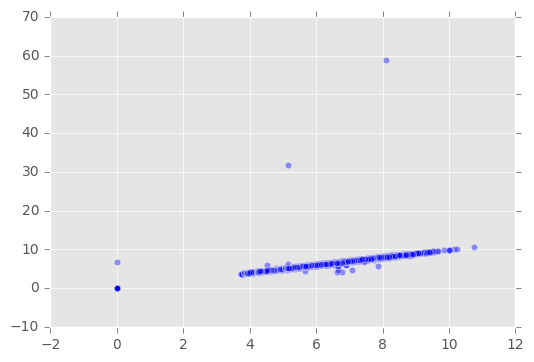

In [9]:
% matplotlib inline
from matplotlib import pyplot as plt
from pydataset import data
plt.style.use(style='ggplot')

d = data('diamonds')
plt.scatter(x =d.x, y=d.y, alpha=.4)

Great resource
https://github.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/blob/master/ipynb/Chapter%201%20-%20Mining%20Twitter.ipynb

Go to twitter dev to get an API key.
https://dev.twitter.com/apps

Must add a phone number. 